In [1]:
import pandas as pd
import numpy as np

In [2]:
mydata = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

In [3]:
mydata.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [4]:
mydata.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


<Axes: >

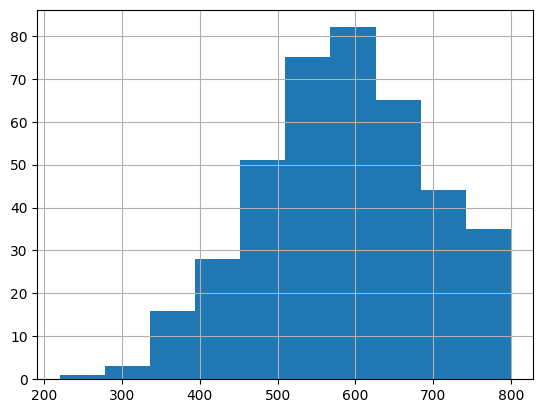

In [5]:
mydata['gre'].hist()


<Axes: xlabel='rank'>

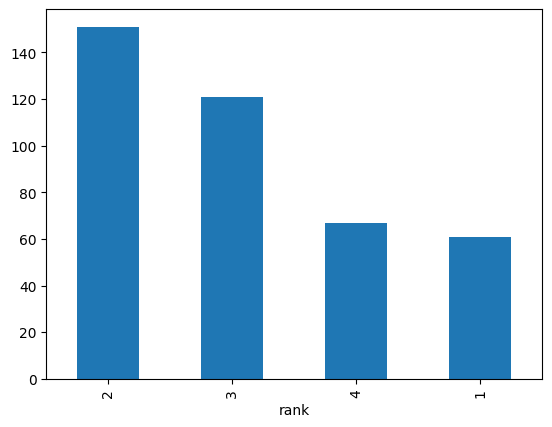

In [6]:
mydata['rank'].value_counts().plot(kind='bar')


In [8]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [9]:
iv, woe = iv_woe(data = mydata, target = 'admit', bins=10, show_woe = True)
print(iv)
print(woe)

Information value of gre is 0.312882
  Variable            Cutoff   N  Events  % of Events  Non-Events  \
0      gre  (219.999, 440.0]  48       6     0.047244          42   
1      gre    (440.0, 500.0]  51      12     0.094488          39   
2      gre    (500.0, 520.0]  24      10     0.078740          14   
3      gre    (520.0, 560.0]  51      15     0.118110          36   
4      gre    (560.0, 580.0]  29       6     0.047244          23   
5      gre    (580.0, 620.0]  53      21     0.165354          32   
6      gre    (620.0, 660.0]  45      17     0.133858          28   
7      gre    (660.0, 680.0]  20       9     0.070866          11   
8      gre    (680.0, 740.0]  44      12     0.094488          32   
9      gre    (740.0, 800.0]  35      19     0.149606          16   

   % of Non-Events       WoE        IV  
0         0.153846  1.180625  0.125857  
1         0.142857  0.413370  0.019994  
2         0.051282 -0.428812  0.011774  
3         0.131868  0.110184  0.001516 

In [10]:
mydata

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


In [60]:
col = mydata["gre"]
target = mydata["admit"]

# # bin strat
# bins = 5
# binned_x = pd.qcut(col, bins)

# bin by assignment
cut_points = [200, 400, 500, 600, 700, np.inf]
binned_x = pd.cut(col, cut_points)

df = pd.DataFrame({'x': col, 'y': target})
df["binned_x"] = binned_x
df = df.groupby("binned_x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
df.columns = ['Cutoff', 'all', 'bads']
df["goods"] = df["all"] - df["bads"]
df.drop("all", axis=1, inplace=True)
df["bads_raw"] = df["bads"]
df["goods_raw"] = df["goods"]
df["bads"] = df["bads"] / df["bads"].sum()
df["goods"] = df["goods"] / df["goods"].sum()
df["gb_odds"] = df["goods"] / df["bads"]
df["WOE"] = np.log(df["goods"] / df["bads"])
df

,Cutoff,bads,goods,bads_raw,goods_raw,gb_odds,WOE
0,"(200.0, 400.0]",0.031496,0.098901,4,27,3.140110,1.144258
1,"(400.0, 500.0]",0.110236,0.197802,14,54,1.794349,0.584642
2,"(500.0, 600.0]",0.314961,0.318681,40,87,1.011813,0.011744
3,"(600.0, 700.0]",0.338583,0.271062,43,74,0.800579,-0.222420
4,"(700.0, inf]",0.204724,0.113553,26,31,0.554663,-0.589394


In [61]:
iv = ((df["goods"] - df["bads"]) * df["WOE"]).sum()
iv


0.19712087148492727

<Axes: >

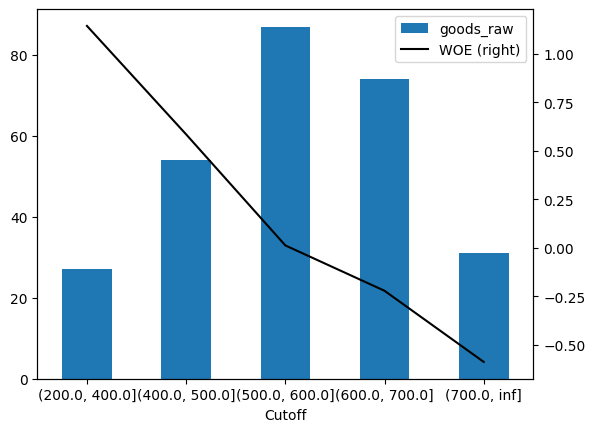

In [62]:
df.plot(x='Cutoff', y=['goods_raw'], kind='bar')
#add a line for the woe in second y axis
import matplotlib.pyplot as plt
df.plot(x='Cutoff', y=['WOE'], secondary_y=True, ax=plt.gca(), color='k')